In [ ]:
!pip install lazypredict-nightly

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

In [ ]:
import time
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [ ]:
import lazypredict
from lazypredict import LazyRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import (
    LinearRegression, Lars, LassoLarsIC, Lasso, ElasticNet, LassoCV, LarsCV,
    LassoLarsCV, ElasticNetCV, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor,
    Ridge, RidgeCV, SGDRegressor, TweedieRegressor, GammaRegressor, PoissonRegressor
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor,
    ExtraTreesRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
)
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


## Preprocessing and feature engineering of the collected data

In [ ]:
# Load data
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/docking_results/docking_scores_data.csv
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/descriptors_data/RDKit_descriptors.csv

--2024-12-10 17:44:26--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/docking_results/docking_scores_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338231 (330K) [text/plain]
Saving to: ‘docking_scores_data.csv’

docking_scores_data 100%[===================>] 330.30K  --.-KB/s    in 0.04s   

2024-12-10 17:44:26 (7.53 MB/s) - ‘docking_scores_data.csv’ saved [338231/338231]

--2024-12-10 17:44:26--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/descriptors_data/RDKit_descriptors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

In [ ]:
df = pd.read_csv("docking_scores_data.csv")
df.columns

Index(['smiles', 'Delta_Gibbs'], dtype='object')

In [ ]:
# Handling missing data && cleaning
df = df.dropna(subset=['Delta_Gibbs'])
df = df.drop_duplicates(['smiles']).reset_index(drop=True)
df.shape

(8515, 2)

In [ ]:
# Load RDKit descriptors
RDKit_df = pd.read_csv("RDKit_descriptors.csv")
RDKit_df.shape

(8515, 210)

In [ ]:
# Load PaDEL descriptors
PaDEL_df = pd.read_csv("PaDEL_descriptors.csv")
PaDEL_df.shape

(8515, 1444)

### Exploratory Data Analysis (EDA)

**Frequency plot of Delta Gibbs**

Text(0, 0.5, 'Frequency')

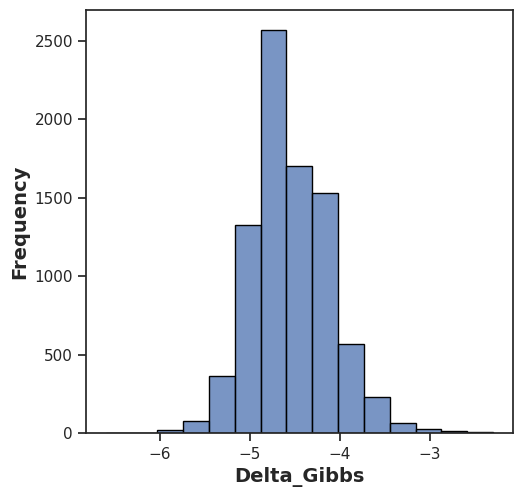

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.histplot(x='Delta_Gibbs', data=df, bins=15, edgecolor='black')

plt.xlabel('Delta_Gibbs', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# plt.savefig('plot_bioactivity_class.pdf')

**Delta Gibbs Box plot**


Text(0, 0.5, 'Delta_Gibbs')

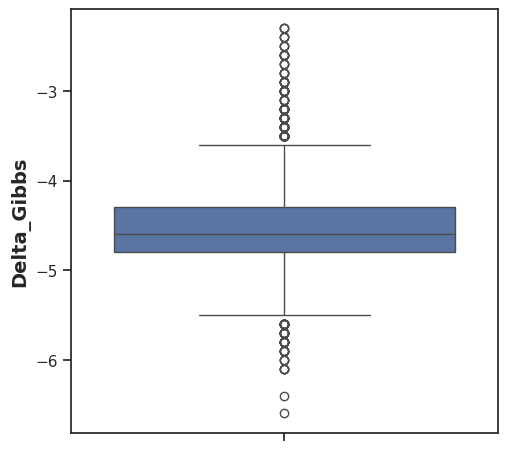

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(y='Delta_Gibbs', data=df)

plt.ylabel('Delta_Gibbs', fontsize=14, fontweight='bold')

** texto en cursivaDescriptors Box Plot**

<Axes: >

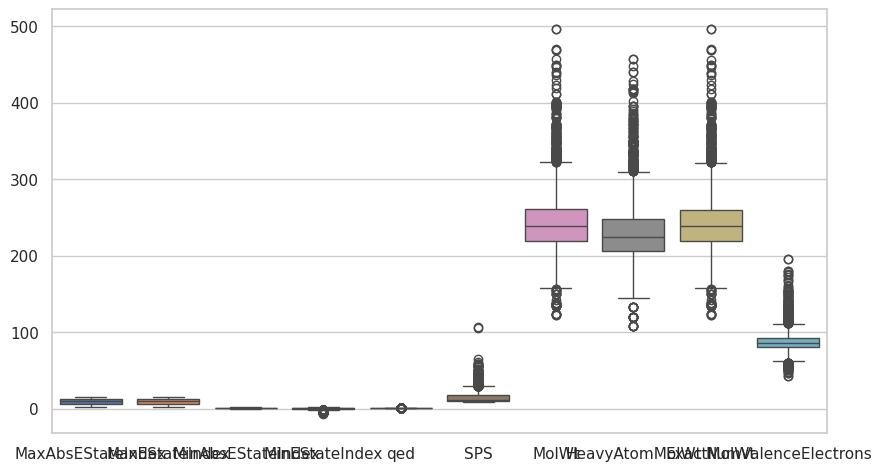

In [ ]:
# RDKit
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=RDKit_df.iloc[:,:10])

<Axes: >

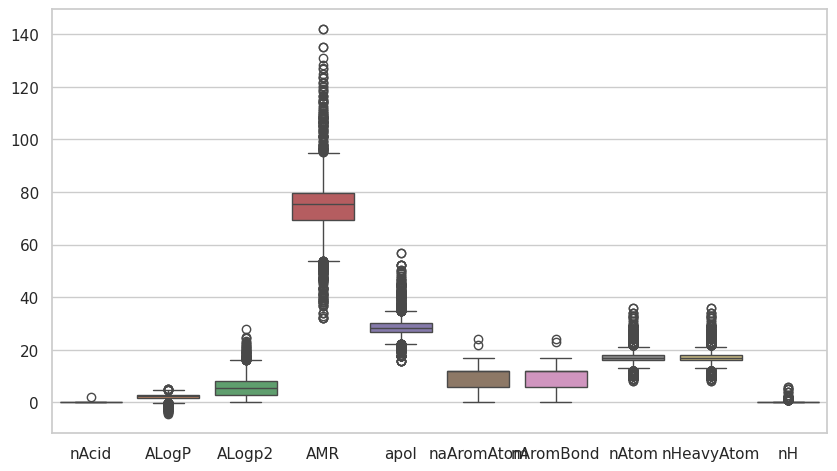

In [ ]:
# PaDEL
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=PaDEL_df.iloc[:,:10])

### Data Cleaning

RDKit descriptors

In [ ]:
RDKit_df.shape

(8515, 210)

In [ ]:
# Drop columns with 90% NaN values
RDKit_df = RDKit_df.loc[:, RDKit_df.isna().mean(axis=0) < 0.9]
RDKit_df.shape

(8515, 210)

In [ ]:
# Drop columns with 90% zeros
RDKit_df = RDKit_df.loc[:, (RDKit_df == 0).mean(axis=0) < 0.9]
RDKit_df.shape

(8515, 129)

PaDEL descriptors

In [ ]:
PaDEL_df.shape

(8515, 1444)

In [ ]:
# Drop columns with 90% NaN values
PaDEL_df = PaDEL_df.loc[:, PaDEL_df.isna().mean(axis=0) < 0.9]
PaDEL_df.shape

(8515, 1377)

In [ ]:
# Drop columns with 90% zeros
PaDEL_df = PaDEL_df.loc[:, (PaDEL_df == 0).mean(axis=0) < 0.9]
PaDEL_df.shape

### Merge RDKit & PaDEL dataframes


In [ ]:
RDKit_PaDEL_df = pd.concat([RDKit_df,PaDEL_df], axis = 1)
RDKit_PaDEL_df.shape

### Detection and handling of outliers


RDKit descriptors

In [ ]:
# Calcular Q1, Q3 y el IQR para las columnas en el DataFrame
Q1 = RDKit_df.quantile(0.25)
Q3 = RDKit_df.quantile(0.75)
IQR = Q3 - Q1

# Crear un filtro para identificar los índices de las filas que quedan
RDKit_filter = ~((RDKit_df < (Q1 - 1.5 * IQR)) | (RDKit_df > (Q3 + 1.5 * IQR))).any(axis=1)
RDKit_cleaned = RDKit_df[RDKit_filter].reset_index(drop=True)

# Filtrar el dataframe con los Delta Gibbs
df_cleaned_1 = df[RDKit_filter].reset_index(drop=True)
RDKit_cleaned.shape

(99, 129)

PaDEL descriptors

In [ ]:
# Calcular Q1, Q3 y el IQR para las columnas en el DataFrame
Q1 = PaDEL_df.quantile(0.25)
Q3 = PaDEL_df.quantile(0.75)
IQR = Q3 - Q1

# Crear un filtro para identificar los índices de las filas que quedan
PaDEL_filter = ~((PaDEL_df < (Q1 - 1.5 * IQR)) | (PaDEL_df > (Q3 + 1.5 * IQR))).any(axis=1)
PaDEL_cleaned = PaDEL_df[PaDEL_filter].reset_index(drop=True)

# Filtrar el dataframe con los Delta Gibbs
df_cleaned_2 = df[PaDEL_filter].reset_index(drop=True)
PaDEL_cleaned.shape

(99, 129)

RDKit & PaDEL descriptors

In [ ]:
# Calcular Q1, Q3 y el IQR para las columnas en el DataFrame
Q1 = RDKit_PaDEL_df.quantile(0.25)
Q3 = RDKit_PaDEL_df.quantile(0.75)
IQR = Q3 - Q1

# Crear un filtro para identificar los índices de las filas que quedan
RDKit_PaDEL_filter = ~((RDKit_PaDEL_df < (Q1 - 1.5 * IQR)) | (RDKit_PaDEL_df > (Q3 + 1.5 * IQR))).any(axis=1)
RDKit_PaDEL_cleaned = RDKit_PaDEL_df[RDKit_PaDEL_filter].reset_index(drop=True)

# Filtrar el dataframe con los Delta Gibbs
df_cleaned_3 = df[RDKit_PaDEL_filter].reset_index(drop=True)
RDKit_PaDEL_cleaned.shape

**Descriptors Box Plot**

<Axes: >

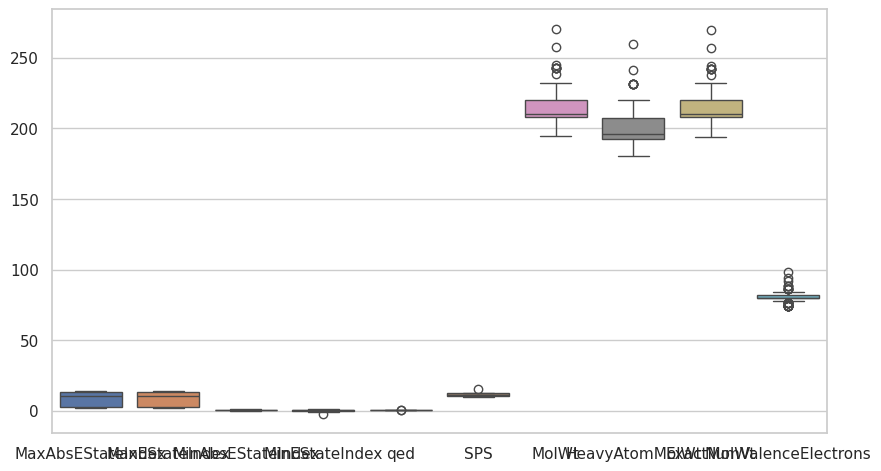

In [ ]:
# RDKit
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=RDKit_cleaned.iloc[:,:10])

In [ ]:
# PaDEL
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=PaDEL_cleaned.iloc[:,:10])

### Data Transformation

In [ ]:
# Initialization of data scalers
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

In [ ]:
# Scale data
RDKit_scaled = robust_scaler.fit_transform(RDKit_cleaned)
RDKit_scaled = minmax_scaler.fit_transform(RDKit_scaled)

# Create RDKit scaled DataFrame
RDKit_columns = RDKit_cleaned.columns
RDKit_scaled = pd.DataFrame(RDKit_scaled)
RDKit_scaled.columns = RDKit_columns
RDKit_scaled.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_NH0,fr_allylic_oxid,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_para_hydroxylation,fr_sulfide
count,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,...,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00
mean,0.54,0.54,0.43,0.68,0.55,0.23,0.27,0.26,0.27,0.28,...,0.01,0.00,0.37,0.00,0.00,0.00,0.04,0.32,0.00,0.00
std,0.40,0.40,0.30,0.22,0.17,0.16,0.18,0.18,0.18,0.18,...,0.10,0.00,0.38,0.00,0.00,0.00,0.20,0.36,0.00,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.01,0.01,0.16,0.54,0.47,0.13,0.18,0.15,0.18,0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.71,0.71,0.40,0.66,0.52,0.16,0.21,0.20,0.21,0.25,...,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.50,0.00,0.00
75%,0.91,0.91,0.56,0.83,0.67,0.43,0.34,0.34,0.34,0.33,...,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.50,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00


<Axes: >

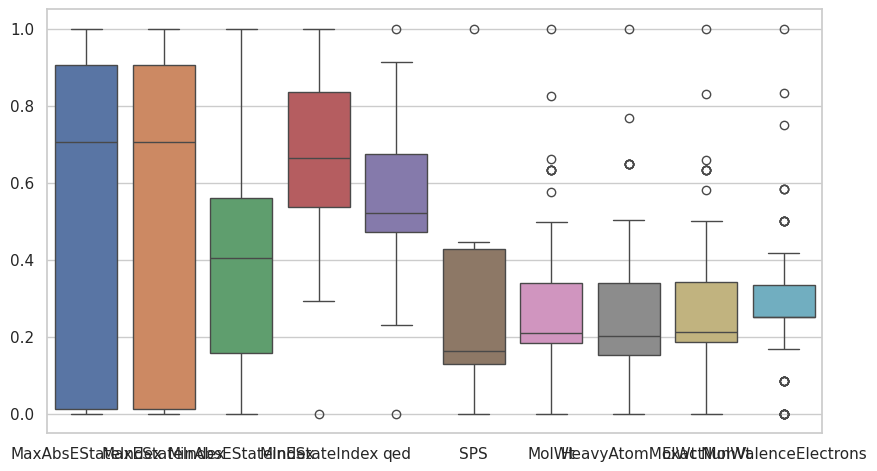

In [ ]:
# RDKit
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=RDKit_scaled.iloc[:,:10])

In [ ]:
# Scale data
PaDEL_scaled = robust_scaler.fit_transform(PaDEL_cleaned)
PaDEL_scaled = minmax_scaler.fit_transform(PaDEL_scaled)

# Create PaDEL scaled DataFrame
PaDEL_columns = PaDEL_cleaned.columns
PaDEL_scaled = pd.DataFrame(PaDEL_scaled)
PaDEL_scaled.columns = PaDEL_columns
PaDEL_scaled.describe()

,nAcid,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,nB,nC,nN,...,MW,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,Zagreb
count,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,...,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00
mean,0.00,0.31,0.42,0.42,0.31,0.31,0.00,0.00,0.45,0.06,...,0.34,0.20,0.32,0.31,0.27,0.09,0.06,0.12,0.26,0.28
std,0.01,0.08,0.14,0.14,0.08,0.08,0.03,0.00,0.08,0.09,...,0.10,0.08,0.08,0.07,0.17,0.10,0.10,0.06,0.09,0.09
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.27,0.25,0.25,0.29,0.29,0.00,0.00,0.40,0.00,...,0.28,0.15,0.29,0.27,0.12,0.00,0.00,0.09,0.21,0.22
50%,0.00,0.31,0.50,0.50,0.32,0.32,0.00,0.00,0.44,0.00,...,0.33,0.19,0.33,0.30,0.23,0.09,0.00,0.11,0.26,0.26
75%,0.00,0.35,0.50,0.50,0.36,0.36,0.00,0.00,0.48,0.14,...,0.40,0.23,0.37,0.34,0.36,0.12,0.14,0.14,0.31,0.32
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
# Scale data
RDKit_PaDEL_scaled = robust_scaler.fit_transform(RDKit_PaDEL_cleaned)
RDKit_PaDEL_scaled = minmax_scaler.fit_transform(RDKit_PaDEL_scaled)

# Create RDKit & PaDEL scaled DataFrame
RDKit_PaDEL_columns = RDKit_PaDEL_cleaned.columns
RDKit_PaDEL_scaled = pd.DataFrame(RDKit_PaDEL_scaled)
RDKit_PaDEL_scaled.columns = RDKit_PaDEL_columns
RDKit_PaDEL_scaled.describe()

### Prepare the output/input dataframes

*   **Input:** RDKit or PaDEL or RDKit & PaDEL descriptors
*   **Output:** Delta Gibbs value

In [ ]:
# RDKit
input_1 = RDKit_scaled
output_1 = df_cleaned_1.iloc[:,-1]

In [ ]:
# PaDEL
input_2 = PaDEL_scaled
output_2 = df_cleaned_2.iloc[:,-1]

In [ ]:
# RDKit & PaDEL
input_3 = RDKit_PaDEL_scaled
output_3 = df_cleaned_3.iloc[:,-1]

### Dimension Reduction Technique : PCA

RDKit descriptors

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

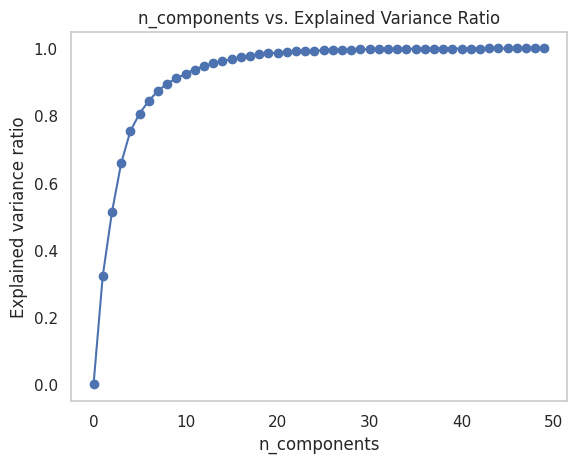

In [ ]:
nums = np.arange(50)
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(input_1)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure()
plt.plot(nums,var_ratio,marker='o')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

In [ ]:
pca = PCA(n_components=20)
PCA_input_1 = pca.fit_transform(input_1)

PaDEL descriptors

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

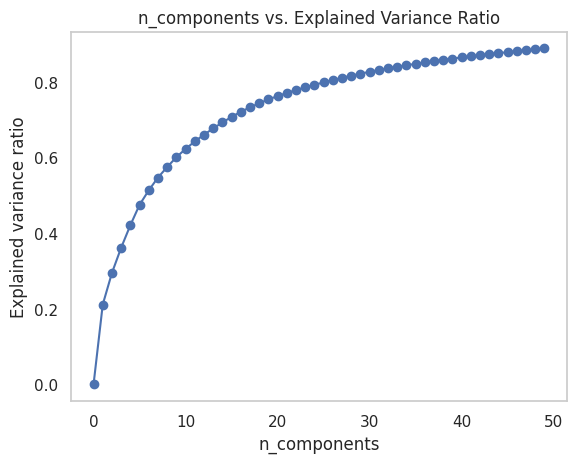

In [ ]:
nums = np.arange(50)
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(input_2)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure()
plt.plot(nums,var_ratio,marker='o')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

In [ ]:
pca = PCA(n_components=50)
PCA_input_2 = pca.fit_transform(input_2)

RDKit & PaDEL descriptors

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

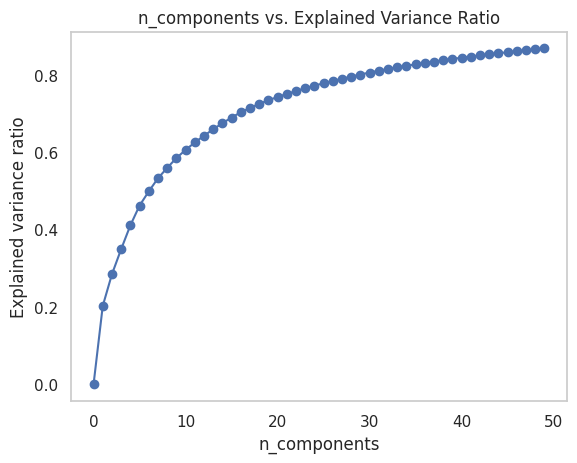

In [ ]:
nums = np.arange(50)
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(input_3)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure()
plt.plot(nums,var_ratio,marker='o')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

In [ ]:
pca = PCA(n_components=50)
PCA_input_3 = pca.fit_transform(input_3)

In [ ]:
# Split the data to training and testing
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(PCA_input_1, output_1, test_size=0.30, random_state=3) # RDKit
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(PCA_input_2, output_2, test_size=0.30, random_state=3) # PaDEL
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(PCA_input_3, output_3, test_size=0.30, random_state=3) # RDKit & PaDEL

## Apply Machine Learning Algorithms

### Apply Lazy Regressor

RDKit descriptors

In [ ]:
# Defines and builds the lazyregressor
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models_1, predictions_1 = clf.fit(X_train_1, X_test_1, Y_train_1, Y_test_1)

100%|██████████| 42/42 [00:01<00:00, 22.92it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 69, number of used features: 20
[LightGBM] [Info] Start training from score -4.814493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[(0.0, 1.0)]

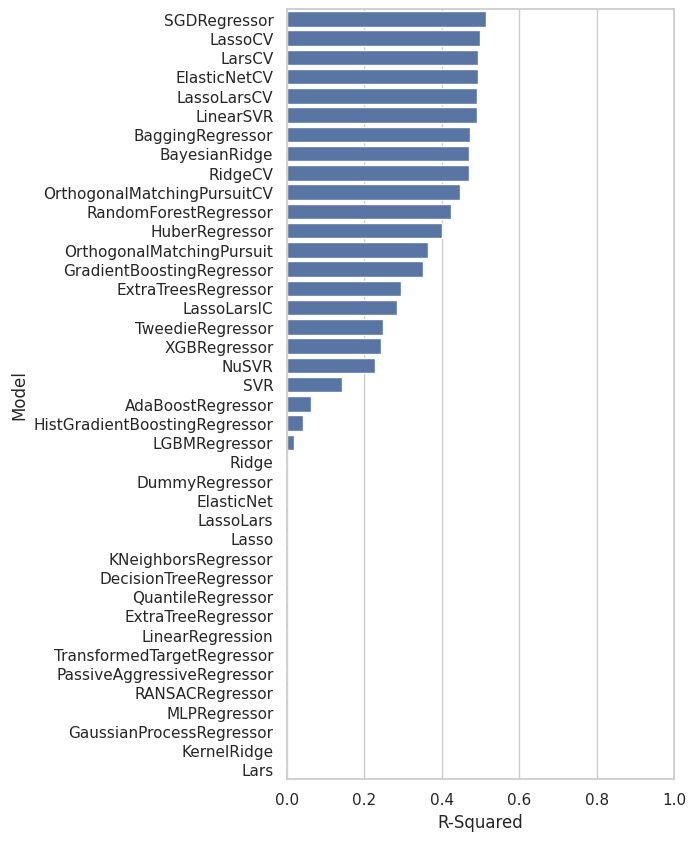

In [ ]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_1.index, x="R-Squared", data=predictions_1)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

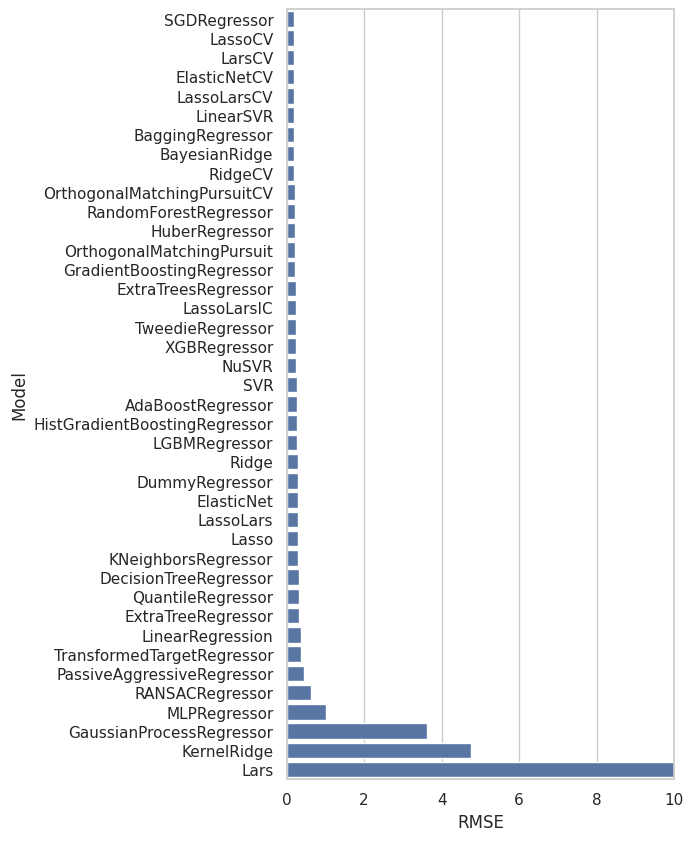

In [ ]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_1.index, x="RMSE", data=predictions_1)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

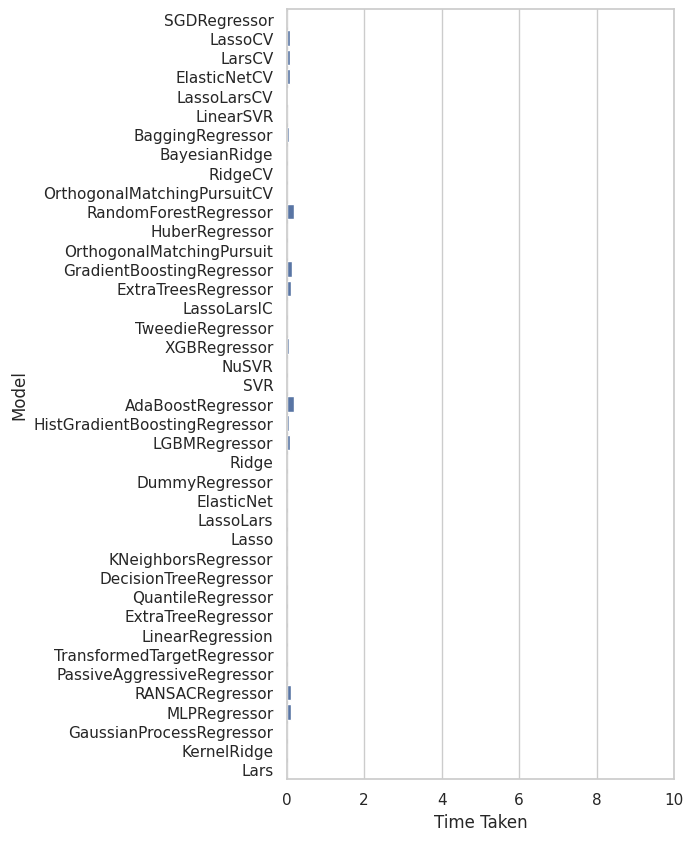

In [ ]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_1.index, x="Time Taken", data=predictions_1)
ax.set(xlim=(0, 10))

PaDEL descriptors

In [ ]:
# Defines and builds the lazyregressor
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models_2, predictions_2 = clf.fit(X_train_2, X_test_2, Y_train_2, Y_test_2)

 98%|█████████▊| 41/42 [02:11<00:02,  2.45s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 5960, number of used features: 50
[LightGBM] [Info] Start training from score -4.540419


100%|██████████| 42/42 [02:12<00:00,  3.16s/it]


[(0.0, 1.0)]

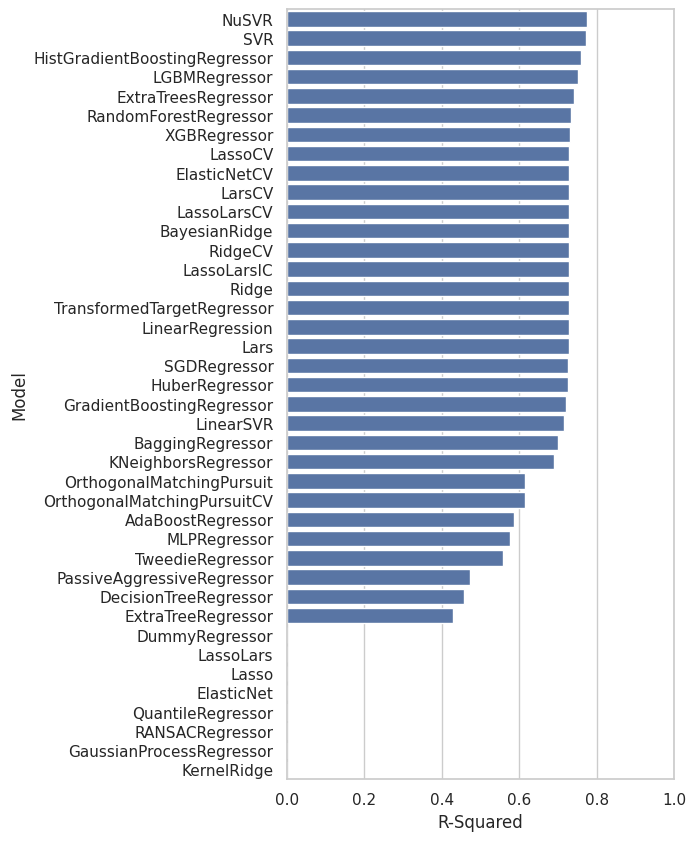

In [ ]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_2.index, x="R-Squared", data=predictions_2)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

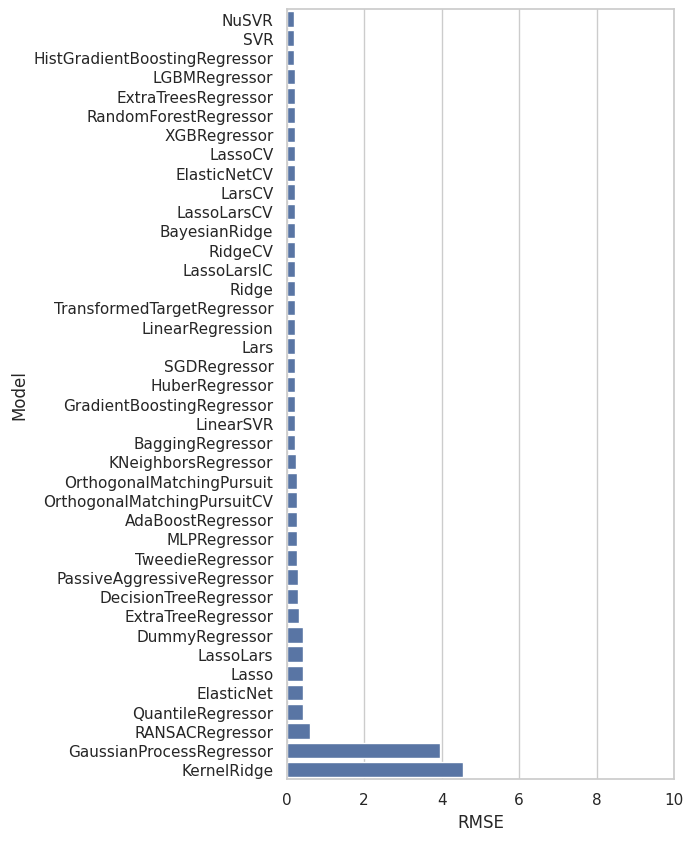

In [ ]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_2.index, x="RMSE", data=predictions_2)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

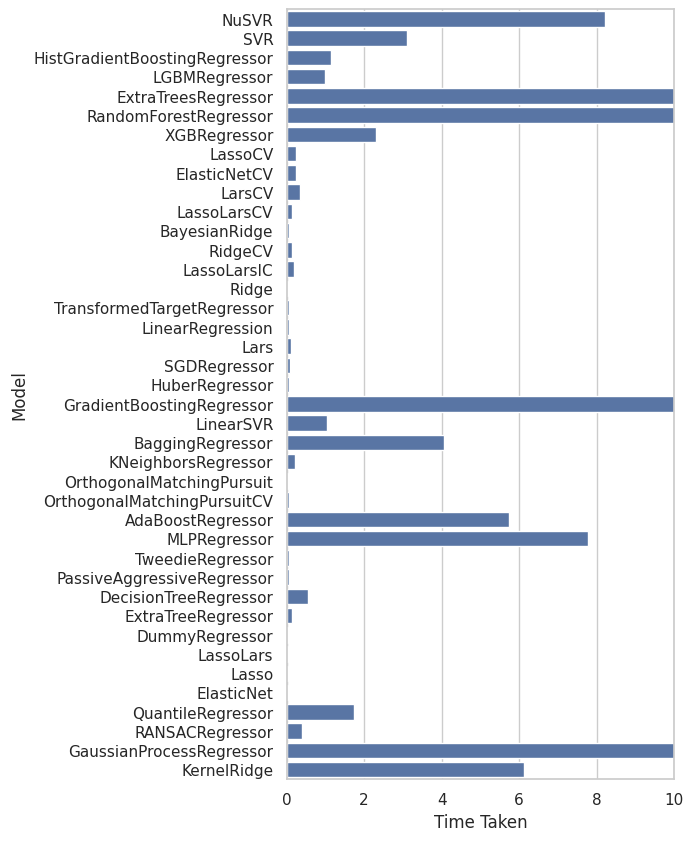

In [ ]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_2.index, x="Time Taken", data=predictions_2)
ax.set(xlim=(0, 10))

RDKit & PADEL descriptors

In [ ]:
# Defines and builds the lazyregressor
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models_3, predictions_3 = clf.fit(X_train_3, X_test_3, Y_train_3, Y_test_3)

 98%|█████████▊| 41/42 [01:59<00:03,  3.03s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 5960, number of used features: 50
[LightGBM] [Info] Start training from score -4.540419


100%|██████████| 42/42 [02:00<00:00,  2.88s/it]


[(0.0, 1.0)]

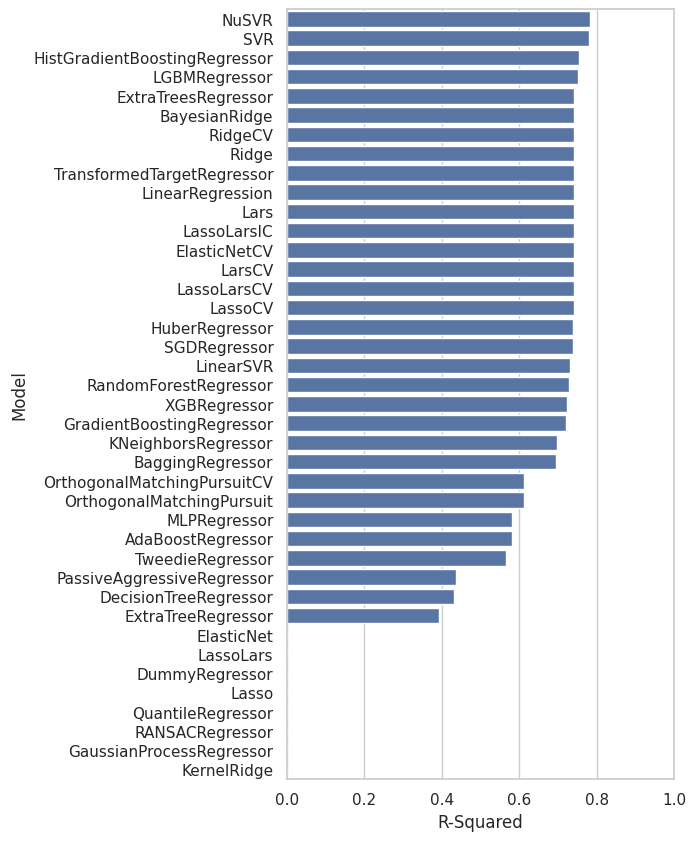

In [ ]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_3.index, x="R-Squared", data=predictions_3)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

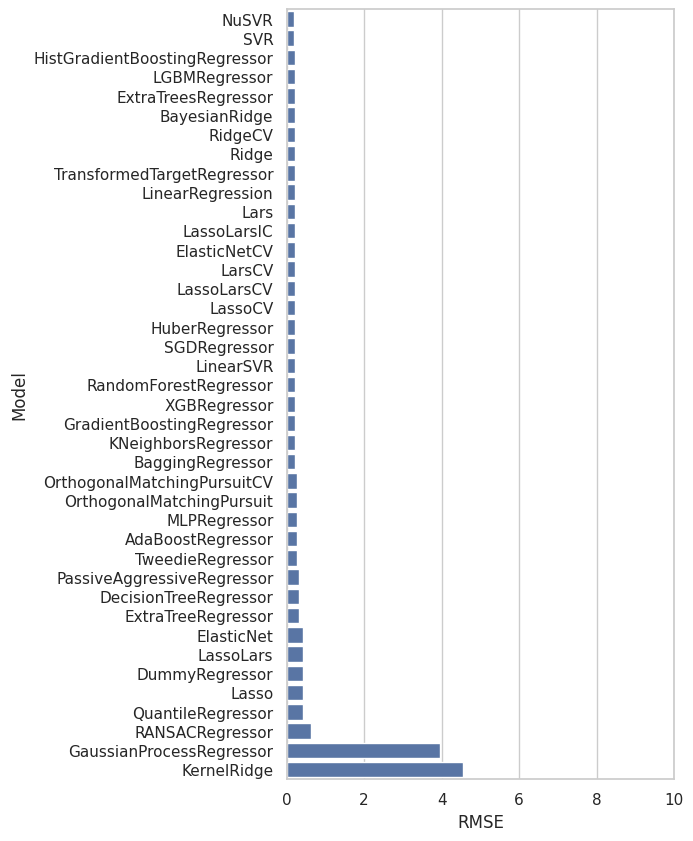

In [ ]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_3.index, x="RMSE", data=predictions_3)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

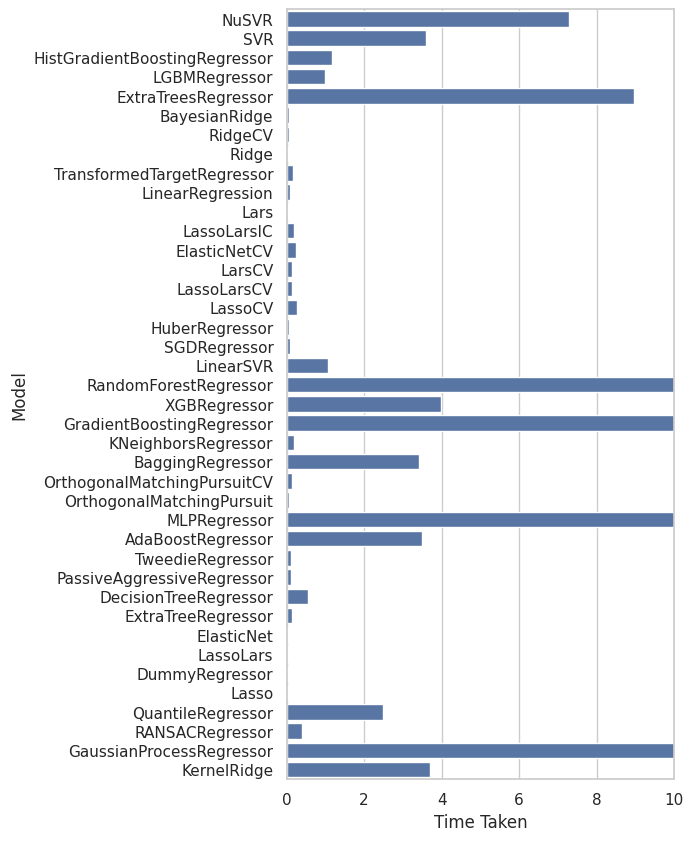

In [ ]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_3.index, x="Time Taken", data=predictions_3)
ax.set(xlim=(0, 10))

### Apply Regressors

In [ ]:
# Regression models
models_ml = {
    "KernelRidge": KernelRidge(),
    "TransformedTargetRegressor": TransformedTargetRegressor(),
    "LinearRegression": LinearRegression(),
    "Lars": Lars(),
    "LassoLarsIC": LassoLarsIC(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "MLPRegressor": MLPRegressor(),
    "RANSACRegressor": RANSACRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "BaggingRegressor": BaggingRegressor(),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
    "LinearSVR": LinearSVR(),
    "SGDRegressor": SGDRegressor(),
    "LassoLarsCV": LassoLarsCV(),
    "LassoCV": LassoCV(),
    "LarsCV": LarsCV(),
    "ElasticNetCV": ElasticNetCV(),
    "Lasso": Lasso(),
    "LassoLars": Lasso(),
    "ElasticNet": ElasticNet(),
    "DummyRegressor": DummyRegressor(),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
    "LGBMRegressor": LGBMRegressor(),
    "OrthogonalMatchingPursuitCV": OrthogonalMatchingPursuitCV(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "ExtraTreeRegressor": ExtraTreeRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(),
    "TweedieRegressor": TweedieRegressor(),
    "GammaRegressor": GammaRegressor(),
    "XGBRegressor": XGBRegressor(),
    "NuSVR": NuSVR(),
    "PoissonRegressor": PoissonRegressor(),
    "Ridge": Ridge(),
    "RidgeCV": RidgeCV(),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(),
    "ExtraTreesRegressor": ExtraTreesRegressor()
}

RDKit descriptors

In [ ]:
print("{:>30} {:>30}".format("MODEL", "SCORE"))
for name, mdl in models_ml.items():
    try:
        kf = KFold(n_splits=5)
        score = cross_val_score(mdl, PCA_input_1, output_1, cv=kf, scoring='r2')
        show_values = [name, np.round(np.mean(score), 2)]
        print("{:>30} {:>30}".format(*show_values), np.round(score, 2))
    except Exception as e:
        print("{:>30} {:>30}".format(name, "error"))

                         MODEL                          SCORE
                   KernelRidge                       -1176.95 [-2010.62  -326.29 -1532.33 -1159.71  -855.79]
    TransformedTargetRegressor                          -0.67 [-0.24  0.63  0.08 -4.09  0.25]
              LinearRegression                          -0.67 [-0.24  0.63  0.08 -4.09  0.25]
                          Lars                          -0.67 [-0.24  0.63  0.08 -4.09  0.25]
                   LassoLarsIC                          -0.27 [-0.24  0.59  0.14 -2.38  0.5 ]
      GaussianProcessRegressor                         -65.12 [ -62.95  -14.84  -76.26 -100.76  -70.81]
                  MLPRegressor                         -14.18 [-19.39  -1.26 -17.11 -25.89  -7.27]
               RANSACRegressor                          -9.06 [ -6.74   0.44  -1.7   -9.08 -28.2 ]
    PassiveAggressiveRegressor                          -0.12 [-1.35  0.44 -0.14 -0.    0.44]
         DecisionTreeRegressor                          -

PaDEL descriptors

In [ ]:
print("{:>30} {:>30}".format("MODEL", "SCORE"))
for name, mdl in models_ml.items():
    try:
        kf = KFold(n_splits=5)
        score = cross_val_score(mdl, PCA_input_2, output_2, cv=kf, scoring='r2')
        show_values = [name, np.round(np.mean(score), 2)]
        print("{:>30} {:>30}".format(*show_values), np.round(score, 2))
    except Exception as e:
        print("{:>30} {:>30}".format(name, "error"))

                         MODEL                          SCORE
                   KernelRidge                        -439.91 [-1211.02  -208.83  -185.08  -214.72  -379.9 ]
    TransformedTargetRegressor                           0.69 [0.77 0.71 0.7  0.64 0.65]
              LinearRegression                           0.69 [0.77 0.71 0.7  0.64 0.65]
                          Lars                           0.69 [0.77 0.71 0.7  0.64 0.65]
                   LassoLarsIC                           0.69 [0.78 0.71 0.7  0.64 0.65]
      GaussianProcessRegressor                         -12.09 [-19.41  -5.08  -5.2  -12.23 -18.55]
                  MLPRegressor                           0.67 [0.74 0.71 0.7  0.6  0.59]
               RANSACRegressor                          -0.93 [-3.03 -0.2  -0.11 -0.31 -1.01]
    PassiveAggressiveRegressor                           0.48 [0.46 0.5  0.45 0.47 0.54]
         DecisionTreeRegressor                           0.33 [0.54 0.34 0.38 0.14 0.22]
     Gradient

RDKit & PaDEL descriptors

In [ ]:
print("{:>30} {:>30}".format("MODEL", "SCORE"))
for name, mdl in models_ml.items():
    try:
        kf = KFold(n_splits=5)
        score = cross_val_score(mdl, PCA_input_3, output_3, cv=kf, scoring='r2')
        show_values = [name, np.round(np.mean(score), 2)]
        print("{:>30} {:>30}".format(*show_values), np.round(score, 2))
    except Exception as e:
        print("{:>30} {:>30}".format(name, "error"))

                         MODEL                          SCORE
                   KernelRidge                        -450.92 [-1252.3   -212.26  -184.98  -217.06  -388.  ]
    TransformedTargetRegressor                           0.69 [0.71 0.72 0.71 0.65 0.64]
              LinearRegression                           0.69 [0.71 0.72 0.71 0.65 0.64]
                          Lars                           0.69 [0.71 0.72 0.71 0.65 0.64]
                   LassoLarsIC                           0.69 [0.72 0.72 0.71 0.65 0.64]
      GaussianProcessRegressor                         -15.82 [-23.92  -7.35  -7.55 -16.85 -23.42]
                  MLPRegressor                           0.66 [0.73 0.7  0.68 0.59 0.59]
               RANSACRegressor                          -0.84 [-0.19 -2.18 -1.09  0.08 -0.85]
    PassiveAggressiveRegressor                           0.45 [0.51 0.58 0.56 0.43 0.16]
         DecisionTreeRegressor                           0.32 [0.55 0.37 0.29 0.19 0.21]
     Gradient